# Part A: Linear Support Vector Machine (SVM)

The dataset used will be the Iris dataset for binary classification, with features of petal length and petal width, and to determine if a sample is Iris Virginica or not. 

In [17]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report


### 1. Implement a Linear_SVC model class for performing binary classification. The model implements the batch Gradient Descent algorithm. 
### 8. EXTRA CREDIT: Implement early stopping in the "fit" method of the Linear_SVC model, using the parameters early_stopping and validation_fraction. This question will also be mentioned when testing it. 

In [18]:
class Linear_SVC:
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=500, early_stopping=False, validation_fraction=0.1,**kwargs):
        self.C = C
        self.w = np.random.rand(2,1)
        self.b = 0      
        self.epochs = max_iter
        self.lr_sc = learning_rate
        self.learning_rate = learning_rate_init
        self.tol = tol 
        self.t_0 = t_0
        self.t_1 = t_1
        self.loss = 1e5
        self.Tloss = 1e5
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
    
    def fit(self,X,y):
        epch_counter = 0        
        val_loss = []
        self.validation_score=1e5
        
        if self.early_stopping:
            X, X_valid, y, y_valid = split_trainTest(X, y, self.validation_fraction)
            
        t = (2 * y - 1)[:,None]
        
        
        while epch_counter < self.epochs:
            loss = self.loss
            epch_counter += 1
            validation_score = self.validation_score
            print(f'Epoch: {epch_counter}')
            w = self.w
            b = self.b
            if(self.lr_sc == "adaptive"):
                self.learning_rate = self.t_0 /(epch_counter + self.t_1)    
        
            idx_sv = ((t * ((X @ w) + b)) < 1).ravel()
            X_sv = X[idx_sv]
            t_sv = t[idx_sv]
            
            self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- (t_sv * (X_sv @ w))) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- X_sv@w) - b* np.sum(t_sv)))).item()
            #self.Tloss = ((0.5 * (w.T @ w))+ (self.C*np.sum((np.maximum(0,1-t*(X@w+b)))))).item()
            # print(self.loss)
            dw = w - (self.C * np.sum(t_sv * X_sv))
            db = -self.C * np.sum(t_sv)
            
            self.w = w - self.learning_rate * dw
            self.b = b - self.learning_rate * db
            self.support_vectors_ = X_sv

            
            if self.early_stopping:
                t_val = (2 * y_valid - 1)[:,None]
                self.validation_score = ((0.5 * (self.w.T @ self.w))+ (self.C * (np.sum(1- (t_val*(X_valid @ self.w))) - b * np.sum(t_val)))).item()
                val_loss.append(self.validation_score)
                if (self.validation_score > validation_score):
                    print(f'\nEarly Stopping at : {epch_counter}\n')
                    plt.plot(range(epch_counter), val_loss, "--", color='darkorange', lw = 2)
                    plt.xlabel("epoch")
                    plt.ylabel("Loss : J(w)")
                    break
            
            if (self.tol != None) and (np.abs(self.loss - loss) < self.tol):         
                break
                    
        self.coef_ = np.array([w])
        self.intercept_ = np.array([b])
        
    def predict(self,X):
        return ((X@self.coef_[0] + self.intercept_[0]) >= 1).astype(np.int)
        
        

## Binary Classification using Linear_SVC Classifier

### 2. Read the Iris data using sklearn.datasets.load_iris. Create data matrix X using petal length and petal width as features, and recode the binary "target" such that Iris-Virginica samples are 1, and the other samples are 0.

In [19]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  
y = (iris["target"] == 2).astype(np.int)[:,None]

In [20]:
Z = np.hstack([X,y])
np.random.shuffle(Z)
X= Z[:,0:2]
y = Z[:,2]

### 3. Partition the data into train and test set, using custom partition function. (80% train, 20% test). 
We also choose to standardize the data.

In [7]:
# Standarize the data
X = (X - np.mean(X))/np.std(X)

def split_trainTest(X,y,t):
    train_size = int((1-t) * X.shape[0])   
    return X[:train_size],X[train_size:],y[:train_size],y[train_size:]

X_train, X_test, y_train, y_test = split_trainTest(X,y,t=0.2)

The below sFold function and s_partition, are a replacement for sklearn kFold function, and helps to find optimal values for hyperparameters.

In [8]:
def sFold(folds,data,labels,model,error_fuction,**model_args):
    if(labels.shape == (labels.shape[0],)):
        labels = np.expand_dims(labels,axis=1)
    dataset = np.concatenate([data,labels],axis=1)
    s_part = s_partition(dataset,folds)
    pred_y = []
    true_y = []
    err_func = []
    for idx,val in enumerate(s_part):
        test_y = val[:,-1]
        #test_y = np.expand_dims(test_y, axis=1)
        test = val[:,:-1]
        train = np.concatenate(np.delete(s_part,idx,0))
        label = train[:,-1]
        train = train[:,:-1]        
        #model.fit(train,label,**model_args) 
        model.fit(train,label)  
        pred = model.predict(test)
        
        pred_y.append(pred)
        true_y.append(test_y[:,None])
        err_func.append(error_fuction(pred,test_y[:,None]))
    avg_error = np.array(err_func).mean()
    result = {'Expected labels':true_y, 'Predicted labels': pred_y,'Average error':avg_error }
    return result

def s_partition(x,s):
    return np.array_split(x,s)

def accuracy(x,y):
    x,y = np.array(x),np.array(y)
    pred = (x == y).astype(np.int)
    return pred.mean()

### 4. Use the sFold function to find optimal values for the hyperparameters: C, learning_rate, learning_rate_init, max_iter, and tol. 

In [21]:
def findOptimalSVM():
    validation_accuracy = np.empty((4,4,2,5,5))
    learning_rate_init = [0.1 , 0.01, 0.001, 0.0001]
    C = [ 1 , 35, 50, 100]
    learning_rate= ['constant', 'adaptive']
    max_iter = [10, 35, 50, 100, 500]
    tol = [None, 0.1, 1, 0.01, 5]
    maxScore = 0
    for i,lri in enumerate(learning_rate_init):
        for j,c in enumerate(C):
            for k,lr in enumerate(learning_rate):
                for l,mi in enumerate(max_iter):
                    for m,tl in enumerate(tol):
                        model_args = {'learning_rate' : lr,'C':c,'learning_rate_init' : lri,'max_iter' : mi,'tol' : tl}
                        lrSvM = Linear_SVC(**model_args) 
                        result = sFold(5,X,y,lrSvM, error_fuction = accuracy,**model_args)
                        validation_accuracy[i,j,k,l,m] = result['Average error']
                        if validation_accuracy[i,j,k,l,m] > maxScore:
                            maxScore = validation_accuracy[i,j,k,l,m]
                            index = [i,j,k,l,m]

    print(index)
    a,b,c,d,e= index
    print('optimal learning_rate_init: ',learning_rate_init[a])
    print('optimal C: ',C[b])
    print('optimal learning_rate: ',learning_rate[c])
    print('optimal max_iter',max_iter[d])
    print('optimal tol',tol[e])
    print('optimal value',validation_accuracy[a,b,c,d,e])
    opt_dic = {'learning_rate' : learning_rate[c],'C':C[b],'learning_rate_init' : learning_rate_init[a],'max_iter' : max_iter[d],'tol' : tol[e]}   
    return opt_dic

In [22]:
opt_mod = findOptimalSVM()

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 

Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 5

Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 1

Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 5

Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch:

Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267

Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233

Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260

Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417

Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Ep

Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444

Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456

Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6


Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91


Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch:

Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380

Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4

Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379

Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423

Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 1

Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330

Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2

Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 

Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 2

Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 6

Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9

Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385

Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485

Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epo

Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211

Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298

Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414

Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424

Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482

Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 8

Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190

Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231

Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408

Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 

Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 4

Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 3

Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272

Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347

Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373

Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372

Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262

Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch:

Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
E

Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 3

Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 3

Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 5

Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 1

Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58


Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
E

Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
E

Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Ep

Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489

Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493

Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479

Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36


Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149


Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epo

Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 10

Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7

Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 7

Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 3

Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 

Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch:

Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 

Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 

Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Ep

Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422

Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343

Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 1

Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoc

Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 

Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 3

Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 6

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433

Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495

Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 

Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149


Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 13

Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch

Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159


Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194

Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 7

Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epo

Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377

Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333

Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325

Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 

Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 4

Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 1

Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 7

Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 3

Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Ep

Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
E

Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Ep

Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Ep

Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch

Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Ep

Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
E

Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234

Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226

Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91


Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 

Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 4

Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 6

Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 1

Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200

Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229

Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251

Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293

Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308

Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283

Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212

Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286

Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch:

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2


Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 4

Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 3

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Ep

Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoc

Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64

Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73

Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch:

Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 

Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 3

Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 9

Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 1

Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383

Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461

Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492

Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epo

Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoc

Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch

Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243

Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321

Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367

Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424

Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396

Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424

Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch

Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 3

Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 4

Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 5

Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epo

Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499

Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421

Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457

Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epo

Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch:

Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270

Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298

Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330

Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch:

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 

Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 3

Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 6

Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 3

Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epo

Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221

Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch:

Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416

Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427

Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410

Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296

Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244

Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210

Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoc

Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411

Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch:

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 3

Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 7

Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 2

Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 4

Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453

Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454

Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439

Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303

Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294

Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492

Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139


Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264

Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 

Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 4

Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 3

Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 6

Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 4

Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383

Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382

Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395

Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465

Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344

Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243

Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180

Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 

Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
E

Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432

Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387

Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
E

Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 

Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 3

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 9

Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201

Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203

Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoc

Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254

Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch

Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch:

Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200

Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 15

Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242

Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104


Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epo

Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epo

Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 3

Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38


Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193

Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271

Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 1
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 1
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch

Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 2

Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 5

Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 9

Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497

Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
E

Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333

Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 

Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 4

Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 9

Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 5

Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 8

Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119


Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340

Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202

Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207

Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284

Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Ep

Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 

Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 3

Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 2

Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 4

Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 6

Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389

Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496

Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350

Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435

Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 18

Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89

Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198

Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 

Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 2

Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 4

Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 6

Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 1

Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 

Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237

Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249

Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch

Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313

Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218

Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 6

Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492

Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211

Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236

Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 8

Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 1

Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch:

Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 

Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoc

Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 

Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 

Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 4

Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59

Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272

Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch:

Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epo

Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoc

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 1

Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 3

Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 

Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epo

Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 13

Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271

Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265

Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200

Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351

Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303

Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370

Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199

Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
E

Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 4

Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9

Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 9

Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411

Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91


Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Ep

Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
E

Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46

Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch

Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374

Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394

Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403

Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoc

Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 

Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Ep

Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Ep

Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epo

Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoc

Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
E

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10

Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84

Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286

Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205

Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch:

Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoc

Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459

Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Ep

Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332

Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407

Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384

Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462

Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47


Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epo

Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325

Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350

Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch:

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 2

Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 5

Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 9

Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch

Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 

Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epo

Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch:

Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 

Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98

Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246

Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324

Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoc

Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 2

Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 3

Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 8

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch:

Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoc

Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch

Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149


Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 

Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202

Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270

Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283

Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337

Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430

Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2


Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 1

Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 5

Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoc

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoc

Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 13

Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 413
Epoch: 414
Epoch: 415
Epoch: 416
Epoch: 417
Epoch: 418
Epoch: 419
Epoch: 420
Epoch: 421
Epoch: 422
Epoch: 423
Epoch: 424
Epoch: 425
Epoch: 426
Epoch: 427
Epoch: 428
Epoch: 429
Epoch: 430
Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450

Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406
Epoch: 407
Epoch: 408
Epoch: 409
Epoch: 410
Epoch: 411
Epoch: 412
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
E

Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epo

Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 1
Epoch: 

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 

Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 8

Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 8

Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204

Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epo

Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179


Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248

Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epo

Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129


Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch

Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46

Epoch: 431
Epoch: 432
Epoch: 433
Epoch: 434
Epoch: 435
Epoch: 436
Epoch: 437
Epoch: 438
Epoch: 439
Epoch: 440
Epoch: 441
Epoch: 442
Epoch: 443
Epoch: 444
Epoch: 445
Epoch: 446
Epoch: 447
Epoch: 448
Epoch: 449
Epoch: 450
Epoch: 451
Epoch: 452
Epoch: 453
Epoch: 454
Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24

Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 101
Epoch: 102
Epoch: 103
Epoch: 104
Epoch: 105
Epoch: 106
Epoch

Epoch: 455
Epoch: 456
Epoch: 457
Epoch: 458
Epoch: 459
Epoch: 460
Epoch: 461
Epoch: 462
Epoch: 463
Epoch: 464
Epoch: 465
Epoch: 466
Epoch: 467
Epoch: 468
Epoch: 469
Epoch: 470
Epoch: 471
Epoch: 472
Epoch: 473
Epoch: 474
Epoch: 475
Epoch: 476
Epoch: 477
Epoch: 478
Epoch: 479
Epoch: 480
Epoch: 481
Epoch: 482
Epoch: 483
Epoch: 484
Epoch: 485
Epoch: 486
Epoch: 487
Epoch: 488
Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Ep

Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoc

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 2

Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 7

Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 3

Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 

Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395
Epoch: 396
Epoch: 397
Epoch: 398
Epoch: 399
Epoch: 400
Epoch: 401
Epoch: 402
Epoch: 403
Epoch: 404
Epoch: 405
Epoch: 406

Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324

Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294

Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274

Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228

Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
E

Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383

Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
E

Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334
Epoch: 335
Epoch: 336
Epoch: 337
Epoch: 338
Epoch: 339
Epoch: 340
Epoch: 341
Epoch: 342
Epoch: 343
Epoch: 344
Epoch: 345
Epoch: 346
Epoch: 347
Epoch: 348
Epoch: 349
Epoch: 350
Epoch: 351
Epoch: 352
Epoch: 353
Epoch: 354
Epoch: 355
Epoch: 356
Epoch: 357
Epoch: 358
Epoch: 359
Epoch: 360
Epoch: 361
Epoch: 362
Epoch: 363
Epoch: 364
Epoch: 365
Epoch: 366
Epoch: 367
Epoch: 368
Epoch: 369
Epoch: 370
Epoch: 371
Epoch: 372
Epoch: 373
Epoch: 374
Epoch: 375
Epoch: 376
Epoch: 377
Epoch: 378
Epoch: 379
Epoch: 380
Epoch: 381
Epoch: 382
Epoch: 383
Epoch: 384
Epoch: 385
Epoch: 386
Epoch: 387
Epoch: 388
Epoch: 389
Epoch: 390
Epoch: 391
Epoch: 392
Epoch: 393
Epoch: 394
Epoch: 395

Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219
Epoch: 220
Epoch: 221
Epoch: 222
Epoch: 223
Epoch: 224
Epoch: 225
Epoch: 226
Epoch: 227
Epoch: 228
Epoch: 229
Epoch: 230
Epoch: 231
Epoch: 232
Epoch: 233
Epoch: 234
Epoch: 235
Epoch: 236
Epoch: 237
Epoch: 238
Epoch: 239
Epoch: 240
Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263

Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194
Epoch: 195
Epoch: 196
Epoch: 197
Epoch: 198
Epoch: 199
Epoch: 200
Epoch: 201
Epoch: 202
Epoch: 203
Epoch: 204
Epoch: 205
Epoch: 206
Epoch: 207
Epoch: 208
Epoch: 209
Epoch: 210
Epoch: 211
Epoch: 212
Epoch: 213
Epoch: 214
Epoch: 215
Epoch: 216
Epoch: 217
Epoch: 218
Epoch: 219

Epoch: 104
Epoch: 105
Epoch: 106
Epoch: 107
Epoch: 108
Epoch: 109
Epoch: 110
Epoch: 111
Epoch: 112
Epoch: 113
Epoch: 114
Epoch: 115
Epoch: 116
Epoch: 117
Epoch: 118
Epoch: 119
Epoch: 120
Epoch: 121
Epoch: 122
Epoch: 123
Epoch: 124
Epoch: 125
Epoch: 126
Epoch: 127
Epoch: 128
Epoch: 129
Epoch: 130
Epoch: 131
Epoch: 132
Epoch: 133
Epoch: 134
Epoch: 135
Epoch: 136
Epoch: 137
Epoch: 138
Epoch: 139
Epoch: 140
Epoch: 141
Epoch: 142
Epoch: 143
Epoch: 144
Epoch: 145
Epoch: 146
Epoch: 147
Epoch: 148
Epoch: 149
Epoch: 150
Epoch: 151
Epoch: 152
Epoch: 153
Epoch: 154
Epoch: 155
Epoch: 156
Epoch: 157
Epoch: 158
Epoch: 159
Epoch: 160
Epoch: 161
Epoch: 162
Epoch: 163
Epoch: 164
Epoch: 165
Epoch: 166
Epoch: 167
Epoch: 168
Epoch: 169
Epoch: 170
Epoch: 171
Epoch: 172
Epoch: 173
Epoch: 174
Epoch: 175
Epoch: 176
Epoch: 177
Epoch: 178
Epoch: 179
Epoch: 180
Epoch: 181
Epoch: 182
Epoch: 183
Epoch: 184
Epoch: 185
Epoch: 186
Epoch: 187
Epoch: 188
Epoch: 189
Epoch: 190
Epoch: 191
Epoch: 192
Epoch: 193
Epoch: 194

### 5. Train the model using optimal values for the hyperparameters, and evaluate on the test data. Report the test accuracy, and the Test Confusion Matrix

In [23]:
model = Linear_SVC(**opt_mod)

In [24]:
opt_mod

{'learning_rate': 'adaptive',
 'C': 35,
 'learning_rate_init': 0.1,
 'max_iter': 500,
 'tol': 0.01}

In [25]:
model.fit(X_train,y_train)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33


In [26]:
pred = model.predict(X_train)
print("Train Accuracy: ", accuracy_score(pred, y_train))


y_test_predicted = model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


Train Accuracy:  0.9416666666666667
Test Accuracy:  1.0

Test Confusion Matrix:
[[20  0]
 [ 0 10]]


### 7. Plot the decision boundary and show the support vectors using the decision_boundary_support_vectors function.

In [27]:
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)    
    decision_boundary = -(b + w[0]*x1)/w[1]
    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

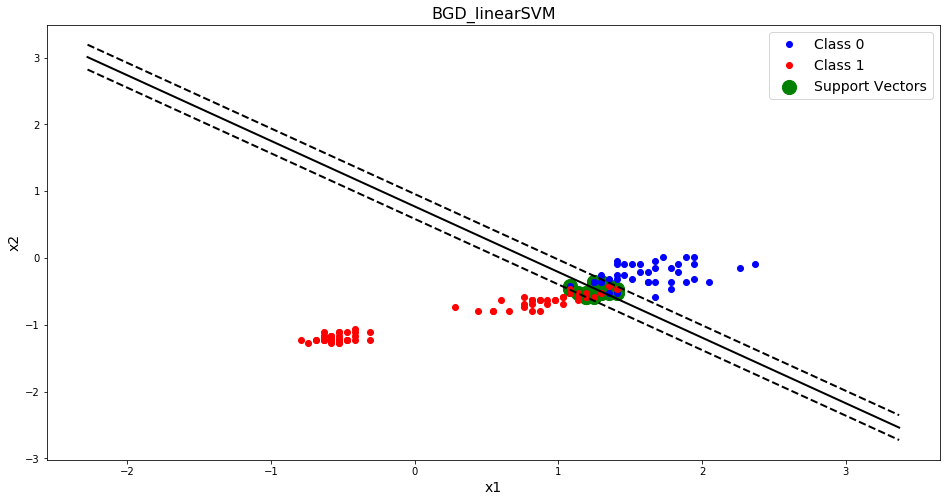

In [28]:
plt.figure(figsize=(16,8))
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="Class 0")
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "ro", label="Class 1")

decision_boundary_support_vectors(model, X_train)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()

### 6. Plot the learning Curve

In [15]:
def mse(Y_true, Y_pred):
    E = np.array(Y_true).reshape(-1,1) - np.array(Y_pred).reshape(-1,1)
    mse = 1/np.array(Y_true).shape[0] * (E.T.dot(E))
    return mse[(0,0)]


def kfold_error(model, X, Y, k_fold, learning_rate = 0.01, epochs = 1000, 
                tol = None, regularizer = None, lambd = 0.0, **kwargs):
    if(Y.shape == (Y.shape[0],)):
        Y = np.expand_dims(Y,axis=1)
    dataset = np.concatenate([X,Y],axis=1)

    k_part = s_partition(dataset, k_fold)   # using the function_1 k_partition
    
    error_training = []
    error_validation = []

    for idx,val in enumerate(k_part):
        validation_Y = val[:,-1]
        validation_X = val[:,:-1]
        train = np.concatenate(np.delete(k_part,idx,0))
        train_Y = train[:,-1]
        train_X = train[:,:-1]          
    
        # using our modeling function
        model.fit(train_X,train_Y)
        pr_train_Y = model.predict(train_X)
        pr_validation_Y = model.predict(validation_X)
        mse_train_Y = mse(train_Y, pr_train_Y)
        mse_validation_Y = mse(validation_Y, pr_validation_Y)

        error_training.append(mse_train_Y)
        error_validation.append(mse_validation_Y)

    # return the average mse for the training and the validation fold.
    return np.array(error_training).mean(), np.array(error_validation).mean()

def learning_curve(model, X, Y, cv, train_size = 1, learning_rate = 0.01, 
                   epochs = 1000, tol = None, regularizer = None, lambd = 0.0, **kwargs):
    
    
    if type(train_size) == int and train_size > 1: 
        train_size_abs = train_size
    elif train_size > 0 and train_size <= 1:
        train_size_abs = int(train_size * X.shape[0])
    else:
        print(f'unaceptable train_size of {train_size}')
    
    # print("train_size:", train_size_abs)
    
    if X.shape[0] % train_size_abs != 0:
        t = X.shape[0] // train_size_abs + 1
    else:
        t = X.shape[0] // train_size_abs
    
    # print("iteration:", t)
    
    t0 = 1
    num_samples_list = []
    rmse_training_list = []
    rmse_validation_list = []

    while t0 <= t:
        i = t0 * train_size_abs
        if i >= X.shape[0]: i = X.shape[0]
        index = np.arange(i)
        X_split = (X[index])
        Y_split = (Y[index])
        
        # using the function_2 to calculate the mse, and then rmse using k-fold based on varying training samples.
        rmse_tr, rmse_va = np.sqrt(kfold_error(model, X_split, Y_split, cv, learning_rate = learning_rate, 
                                               epochs = epochs, tol = tol))
        num_samples_list.append(i)
        rmse_training_list.append(rmse_tr)
        rmse_validation_list.append(rmse_va)
        t0 += 1

    result = {'num_samples':pd.Series(num_samples_list), 
              'train_scores':pd.Series(rmse_training_list), 'val_score':pd.Series(rmse_validation_list)}
    learning_curve_elements = pd.DataFrame(result)
    
    return np.array(learning_curve_elements["train_scores"]), \
            np.array(learning_curve_elements["val_score"]), np.array(learning_curve_elements["num_samples"]), \
            learning_curve_elements

In [16]:
cv = 5
train_size = 15
train_scores, val_scores, train_sizes,_ = learning_curve(Linear_SVC(), X_train, y_train, cv, 
                                                         train_size = train_size, learning_rate = 0.01, 
                                                         epochs = 1000, tol = 1e-5)


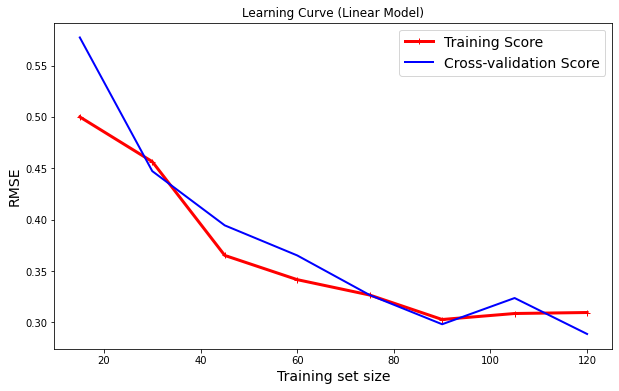

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_scores, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("RMSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

### 8. EXTRA CREDIT: Implement early_stopping, testing portion. This repeats steps 5 and 7 using the early_stopping= True, with a validation fraction which produces an early stopping curve.


Early Stopping at : 5



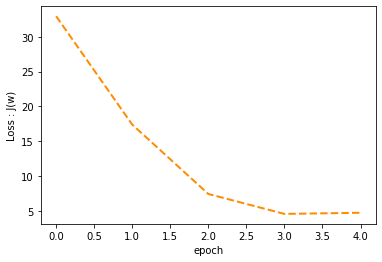

In [18]:
X, y = X_train,y_train
model_early = Linear_SVC(**opt_mod, early_stopping = True, validation_fraction=0.2)
model_early.fit(X,y)

In [19]:
print(model_early.coef_,model_early.intercept_)
support_vectors = model_early.support_vectors_
support_vectors

[[[3.29332106]
  [3.22765789]]] [-2.9]


array([[ 1.40659522, -0.31050983],
       [ 1.29927615, -0.36416936],
       [ 1.35293568, -0.2568503 ],
       [ 1.35293568, -0.52514796],
       [ 1.29927615, -0.52514796],
       [ 1.08463802, -0.41782889],
       [ 1.19195709, -0.47148843],
       [ 1.19195709, -0.57880749],
       [ 1.08463802, -0.47148843],
       [ 1.40659522, -0.2568503 ],
       [ 1.19195709, -0.52514796],
       [ 1.35293568, -0.31050983]])

In [20]:
pred = model_early.predict(X)
print("Train Accuracy: ", accuracy_score(pred, y))


y_test_predicted = model_early.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

Train Accuracy:  0.9333333333333333
Test Accuracy:  0.7666666666666667

Test Confusion Matrix:
[[20  0]
 [ 7  3]]


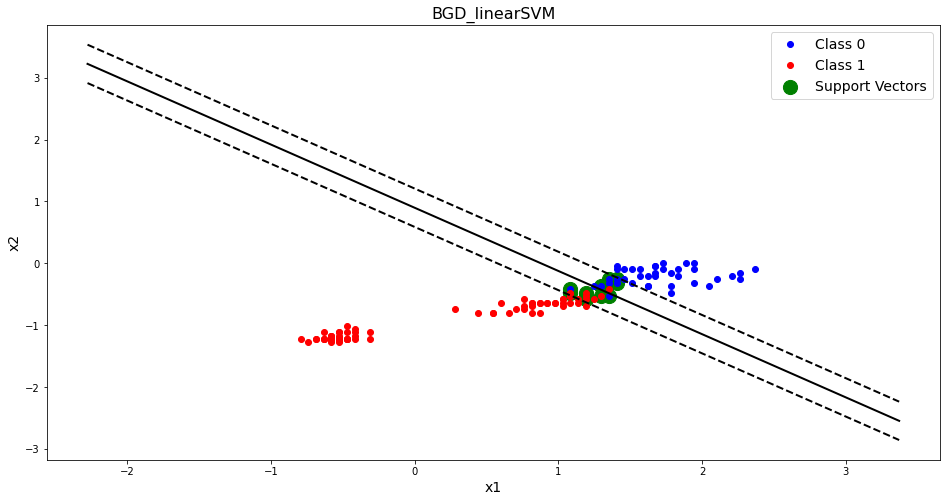

In [21]:
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

decision_boundary_support_vectors(model_early, X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()